
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/pulsar_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[pulsar_analysis.ipynb](../_static/notebooks/pulsar_analysis.ipynb) |
[pulsar_analysis.py](../_static/notebooks/pulsar_analysis.py)
</div>


# Pulsar analysis with Gammapy

## Introduction

This notebook shows how to do a pulsar analysis with Gammapy. It's based on a Vela simulation file from the CTA DC1, which already contains a column of phases. We will produce a phasogram, a phase-resolved map and a phase-resolved spectrum of the Vela pulsar using the class PhaseBackgroundEstimator. 

The phasing in itself is not done here, and it requires specific packages like Tempo2 or [PINT](https://nanograv-pint.readthedocs.io).

## Opening the data

Let's first do the imports and load the only observation containing Vela in the CTA 1DC dataset shipped with Gammapy.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gammapy.utils.regions import SphericalCircleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u

from gammapy.makers import (
    SafeMaskMaker,
    PhaseBackgroundMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import Map, WcsGeom
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, FluxPointsDataset
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

Load the data store (which is a subset of CTA-DC1 data):

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

Define obsevation ID and print events:

In [4]:
id_obs_vela = [111630]
obs_list_vela = data_store.get_observations(id_obs_vela)
print(obs_list_vela[0].events)

EventList info:
- Number of events: 101430
- Median energy: 0.1 TeV
- OBS_ID = 111630


Now that we have our observation, let's select the events in 0.2° radius around the pulsar position.

In [5]:
pos_target = SkyCoord(ra=128.836 * u.deg, dec=-45.176 * u.deg, frame="icrs")
on_radius = 0.2 * u.deg
on_region = SphericalCircleSkyRegion(pos_target, on_radius)

# Apply angular selection
events_vela = obs_list_vela[0].events.select_region(on_region)
print(events_vela)

EventList info:
- Number of events: 843
- Median energy: 0.107 TeV
- OBS_ID = 111630


Let's load the phases of the selected events in a dedicated array.

In [6]:
phases = events_vela.table["PHASE"]

# Let's take a look at the first 10 phases
phases[:10]

0.81847286
0.45646095
0.111507416
0.43416595
0.76837444
0.3639946
0.58693695
0.51095676
0.5606985
0.2505703


## Phasogram

Once we have the phases, we can make a phasogram. A phasogram is a histogram of phases and it works exactly like any other histogram (you can set the binning, evaluate the errors based on the counts in each bin, etc).

In [7]:
nbins = 30
phase_min, phase_max = (0, 1)
values, bin_edges = np.histogram(
    phases, range=(phase_min, phase_max), bins=nbins
)
bin_width = (phase_max - phase_min) / nbins

bin_center = (bin_edges[:-1] + bin_edges[1:]) / 2


# Poissonian uncertainty on each bin
values_err = np.sqrt(values)

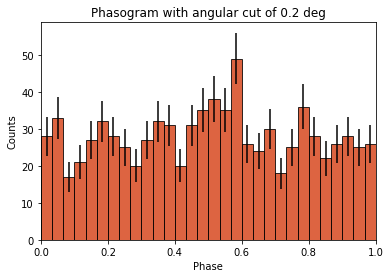

In [8]:
plt.bar(
    x=bin_center,
    height=values,
    width=bin_width,
    color="#d53d12",
    alpha=0.8,
    edgecolor="black",
    yerr=values_err,
)
plt.xlim(0, 1)
plt.xlabel("Phase")
plt.ylabel("Counts")
plt.title(f"Phasogram with angular cut of {on_radius}");

Now let's add some fancy additions to our phasogram: a patch on the ON- and OFF-phase regions and one for the background level.

In [9]:
# Evaluate background level
off_phase_range = (0.7, 1.0)
on_phase_range = (0.5, 0.6)

mask_off = (off_phase_range[0] < phases) & (phases < off_phase_range[1])

count_bkg = mask_off.sum()
print(f"Number of Off events: {count_bkg}")

Number of Off events: 234


In [10]:
# bkg level normalized by the size of the OFF zone (0.3)
bkg = count_bkg / nbins / (off_phase_range[1] - off_phase_range[0])

# error on the background estimation
bkg_err = (
    np.sqrt(count_bkg) / nbins / (off_phase_range[1] - off_phase_range[0])
)

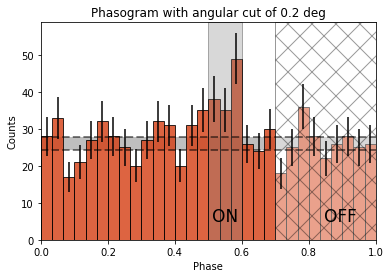

In [11]:
# Let's redo the same plot for the basis
plt.bar(
    x=bin_center,
    height=values,
    width=bin_width,
    color="#d53d12",
    alpha=0.8,
    edgecolor="black",
    yerr=values_err,
)

# Plot background level
x_bkg = np.linspace(0, 1, 50)

kwargs = {"color": "black", "alpha": 0.5, "ls": "--", "lw": 2}

plt.plot(x_bkg, (bkg - bkg_err) * np.ones_like(x_bkg), **kwargs)
plt.plot(x_bkg, (bkg + bkg_err) * np.ones_like(x_bkg), **kwargs)

plt.fill_between(
    x_bkg, bkg - bkg_err, bkg + bkg_err, facecolor="grey", alpha=0.5
)  # grey area for the background level

# Let's make patches for the on and off phase zones
on_patch = plt.axvspan(
    on_phase_range[0], on_phase_range[1], alpha=0.3, color="gray", ec="black"
)

off_patch = plt.axvspan(
    off_phase_range[0],
    off_phase_range[1],
    alpha=0.4,
    color="white",
    hatch="x",
    ec="black",
)

# Legends "ON" and "OFF"
plt.text(0.55, 5, "ON", color="black", fontsize=17, ha="center")
plt.text(0.895, 5, "OFF", color="black", fontsize=17, ha="center")
plt.xlabel("Phase")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.title(f"Phasogram with angular cut of {on_radius}");

## Phase-resolved map

Now that the phases are computed, we want to do a phase-resolved sky map : a map of the ON-phase events minus alpha times the OFF-phase events. Alpha is the ratio between the size of the ON-phase zone (here 0.1) and the OFF-phase zone (0.3).
It's a map of the excess events in phase, which are the pulsed events.

In [12]:
geom = WcsGeom.create(binsz=0.02 * u.deg, skydir=pos_target, width="5 deg")

 Let's create an ON-map and an OFF-map:

In [13]:
on_map = Map.from_geom(geom)
off_map = Map.from_geom(geom)

events_vela_on = events_vela.select_parameter("PHASE", on_phase_range)
events_vela_off = events_vela.select_parameter("PHASE", off_phase_range)

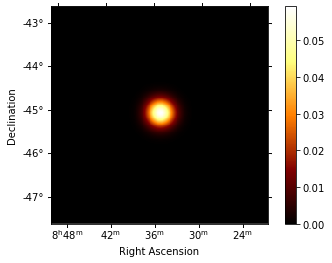

In [14]:
on_map.fill_events(events_vela_on)
off_map.fill_events(events_vela_off)

# Defining alpha as the ratio of the ON and OFF phase zones
alpha = (on_phase_range[1] - on_phase_range[0]) / (
    off_phase_range[1] - off_phase_range[0]
)

# Create and fill excess map
# The pulsed events are the difference between the ON-phase count and alpha times the OFF-phase count
excess_map = on_map - off_map * alpha

# Plot excess map
excess_map.smooth(kernel="gauss", width=0.2 * u.deg).plot(add_cbar=True);

## Phase-resolved spectrum

We can also do a phase-resolved spectrum. In order to do that, there is the class PhaseBackgroundMaker. In a phase-resolved analysis, the background is estimated in the same sky region but in the OFF-phase zone.

In [15]:
e_true = np.logspace(-2.5, 1, 100) * u.TeV
e_reco = np.logspace(-2, 1, 30) * u.TeV

dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)
dataset_maker = SpectrumDatasetMaker()
phase_bkg_maker = PhaseBackgroundMaker(
    on_phase=on_phase_range, off_phase=off_phase_range
)
safe_mask_maker = SafeMaskMaker(
    methods=["aeff-default", "edisp-bias"], bias_percent=20
)

datasets = []

for obs in obs_list_vela:
    dataset = dataset_maker.run(dataset_empty, obs)
    dataset_on_off = phase_bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

No thresholds defined for obs Observation

	obs id            : 111630 
 	tstart            : 59300.83
	tstop             : 59300.85
	duration          : 1800.00 s
	pointing (icrs)   : 130.9 deg, -44.6 deg

	deadtime fraction : 2.0%



Now let's a look at the datasets we just created:

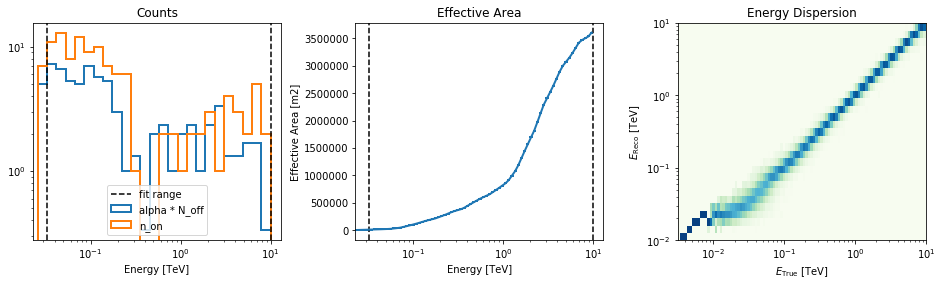

In [16]:
datasets[0].peek()

Now we'll fit a model to the spectrum with the `Fit` class. First we load a power law model with an initial value for the index and the amplitude and then wo do a likelihood fit. The fit results are printed below.

In [17]:
spectral_model = PowerLawSpectralModel(
    index=4, amplitude="1.3e-9 cm-2 s-1 TeV-1", reference="0.02 TeV"
)
model = SkyModel(spectral_model=spectral_model, name="vela psr")
emin_fit, emax_fit = (0.04 * u.TeV, 0.4 * u.TeV)

for dataset in datasets:
    dataset.models = model
    dataset.mask_fit = dataset.counts.geom.energy_mask(
        emin=emin_fit, emax=emax_fit
    )

joint_fit = Fit(datasets)
joint_result = joint_fit.run()

print(joint_result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 108
	total stat : 5.70



Now you might want to do the stacking here even if in our case there is only one observation which makes it superfluous.
We can compute flux points by fitting the norm of the global model in energy bands.

In [18]:
e_edges = np.logspace(np.log10(0.04), np.log10(0.4), 7) * u.TeV

dataset = Datasets(datasets).stack_reduce()

dataset.models = model

fpe = FluxPointsEstimator(e_edges=e_edges, source="vela psr")

flux_points = fpe.run(datasets=[dataset])
flux_points.table["is_ul"] = flux_points.table["ts"] < 1

amplitude_ref = 0.57 * 19.4e-14 * u.Unit("1 / (cm2 s MeV)")
spec_model_true = PowerLawSpectralModel(
    index=4.5, amplitude=amplitude_ref, reference="20 GeV"
)

flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)

/Users/terrier/Code/gammapy-dev/gammapy-docs/build/v0.17/gammapy/gammapy/estimators/parameter_estimator.py:172: RuntimeWarning: invalid value encountered in sqrt
  {"sqrt_ts": np.sqrt(res), "ts": res, "null_value": null_value}


Now we can plot.

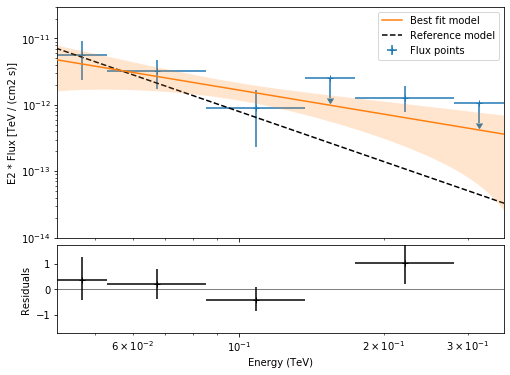

In [19]:
plt.figure(figsize=(8, 6))
ax_spectrum, ax_residual = flux_points_dataset.peek()

ax_spectrum.set_ylim([1e-14, 3e-11])
ax_residual.set_ylim([-1.7, 1.7])

spec_model_true.plot(
    ax=ax_spectrum,
    energy_range=(emin_fit, emax_fit),
    label="Reference model",
    c="black",
    linestyle="dashed",
    energy_power=2,
)

ax_spectrum.legend(loc="best")

This tutorial suffers a bit from the lack of statistics: there were 9 Vela observations in the CTA DC1 while there is only one here. When done on the 9 observations, the spectral analysis is much better agreement between the input model and the gammapy fit.